## Accelerate Inference: Neural Network Pruning

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.14.0


# Load images

In [2]:
# untar
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [11]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [13]:
# you can use the default hyper-parameters for training,
# val accuracy ~72% after 50 epochs

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=50,
                    validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

Epoch 1/50
703/703 [==============================] - 11s 9ms/step - loss: 1.5060 - accuracy: 0.3160 - val_loss: 1.3687 - val_accuracy: 0.4111
Epoch 2/50
703/703 [==============================] - 5s 7ms/step - loss: 1.3416 - accuracy: 0.4242 - val_loss: 1.2689 - val_accuracy: 0.4558
Epoch 3/50
703/703 [==============================] - 5s 7ms/step - loss: 1.2748 - accuracy: 0.4612 - val_loss: 1.2551 - val_accuracy: 0.4768
Epoch 4/50
703/703 [==============================] - 5s 7ms/step - loss: 1.2287 - accuracy: 0.4944 - val_loss: 1.1924 - val_accuracy: 0.5006
Epoch 5/50
703/703 [==============================] - 4s 6ms/step - loss: 1.1929 - accuracy: 0.5103 - val_loss: 1.1478 - val_accuracy: 0.5212
Epoch 6/50
703/703 [==============================] - 5s 7ms/step - loss: 1.1598 - accuracy: 0.5256 - val_loss: 1.1220 - val_accuracy: 0.5402
Epoch 7/50
703/703 [==============================] - 5s 7ms/step - loss: 1.1337 - accuracy: 0.5402 - val_loss: 1.0899 - val_accuracy: 0.5505
Epoch

In [14]:
results = model.evaluate(val_images, val_labels, batch_size=128)
model.save('model.keras')

20/20 [==============================] - 0s 4ms/step - loss: 0.7137 - accuracy: 0.7236


# Network Pruning

In [136]:
import copy
import gc
from google.colab import files

def get_reward(model,
               train_images,
               train_labels,
               selected_layer,
               sel_input,
               sel_output,
               original_results,
               layer_weights):

    """
    Calculate reward for an arm

    Parameters:
    model: CNN model
    train_images: list, images for model evaluation
    train_labels: list, labels for model evaluation
    selected_layer: int, layer to modify
    sel_input: int, input channel to index for arm of interest
    sel_output: int, output channel to index for arm of interest
    original_results: list, results from model with no zero weights
    layer_weights: np array, weights matrix

    Return
    reward: float, reward for arm of interest

    """

    threshold = 0.005
    constant = 0.05

    temp_w = copy.deepcopy(layer_weights)

    if len(temp_w[0].shape) == 4:
        temp_w[0][:, :, sel_input, sel_output] = 0
    else:
        temp_w[0][:, sel_output] = 0

    temp_w[1][sel_output] = 0
    model.layers[selected_layer].set_weights(temp_w)
    results = model.evaluate(train_images, train_labels, batch_size=2525, workers=2, verbose=0)
    dloss = original_results[0] - results[0]
    reward = max(0, threshold + dloss) / constant
    reward = np.clip(reward, a_min=0, a_max=0.99)

    model.layers[selected_layer].set_weights(layer_weights)
    del temp_w

    gc.collect()

    return reward

def get_sampled_data(train_images,
               train_labels,
               sel_number:int=2500):

    """
    Calculate reward for an arm

    Parameters:
    train_images: list, images for model evaluation
    train_labels: list, labels for model evaluation
    sel_number: int, number of samples to choose

    Return
    sampled_images: list, sampled images for model evaluation
    sampled_labels: list, sampled labels for model evaluation

    """

    rand_idx = np.random.choice(range(len(train_images)), size=sel_number)

    sampled_images = train_images[rand_idx]
    sampled_labels = train_labels[rand_idx]

    return sampled_images, sampled_labels



def MAB(model,
        num_rounds:int,):

    """
    Run multi-armed bandit using UCB1 algorithm

    Parameters:
    model: CNN model
    num_rounds: int, number of rounds on top of initialization run for every arm

    """

    for l in range(18):

      if len(model.layers[l].get_weights()) == 0:
        continue

      print(f'Working on layer {l}')

      layer_weights = model.layers[l].get_weights()
      num_weights = np.prod(layer_weights[0].shape)
      layer_shape = layer_weights[0].shape

      print('Running MAB')
      if l !=13:

        weights_rewards = np.zeros((layer_shape[-2], layer_shape[-1]))
        count = 0

        #initialize experimental means
        for i in range(layer_shape[-2]):

          for out in range(layer_shape[-1]):

              rand_images, rand_labels = get_sampled_data(train_images, train_labels)

              original_results = model.evaluate(rand_images, rand_labels, batch_size=2500, verbose=0)

              weights_rewards[i, out] = get_reward(model,
                                                  rand_images,
                                                  rand_labels, l, i, out,
                                                  original_results,
                                                  layer_weights)
              count += 1

              if count%100 == 0:
                print(f'Arms tested: {count}')

      #special case for dense layer since there are too many parameters
      else:
        weights_rewards = np.zeros((1, layer_shape[-1]))
        count = 0

        #initialize experimental means
        for out in range(layer_shape[-1]):

              rand_images, rand_labels = get_sampled_data(train_images, train_labels)

              original_results = model.evaluate(rand_images, rand_labels, batch_size=2500)

              #run UCB1
              weights_rewards[0, out] = get_reward(model,
                                                  val_images,
                                                  val_labels, l, 0, out,
                                                  original_results,
                                                  layer_weights)
              count += 1

              if count%100 == 0:
                print(f'Arms tested: {count}')


      pulls_arr = np.ones_like(weights_rewards)
      total_runs = layer_shape[-2]*layer_shape[-1]

      for r in range(num_rounds):

        #get sampled data
        rand_images, rand_labels = get_sampled_data(train_images, train_labels)
        original_results = model.evaluate(rand_images, rand_labels, batch_size=2500)

        #choose arm to pull
        ait_arr = np.sqrt(2 * np.log(r+total_runs)/pulls_arr)
        arm_pull = np.unravel_index(np.argmax(weights_rewards + ait_arr), weights_rewards.shape)
        reward = get_reward(model, rand_images, rand_labels, l, arm_pull[0], arm_pull[1], original_results, layer_weights)

        #update means
        pulls_arr[arm_pull] += 1
        weights_rewards[arm_pull] = (pulls_arr[arm_pull]-1)/pulls_arr[arm_pull]* weights_rewards[arm_pull] + 1/pulls_arr[arm_pull]*reward

        if r%100 == 0:
          print(f'Done with {r}')

      np.save(f'data_{l}_{cutoff}.npy', weights_rewards)
      files.download(f'data_{l}_{cutoff}.npy')


In [137]:
# perform pruning here

# get the weights
model = keras.models.load_model('model_fixed.keras')
MAB(model, 1000)


Working on layer 0
Running MAB
1/1 [==============================] - 0s 299ms/step - loss: 0.4585 - accuracy: 0.8472


1/1 [==============================] - 0s 60ms/step - loss: 0.4737 - accuracy: 0.8380


KeyboardInterrupt: ignored

# View how accuracy varies with cutoff

In [5]:
import copy

def zero_weights(weights,
                 weights_rewards,
                 l,
                 threshold):

    """
    Zero out a proportion of weights in the given weights matrix according to the rewards.

    Parameters:
    weights: np array, weight matrix
    weights_rewards: np array, weight rewards matrix
    l: int, layer number
    threshold: float, proportion of weights to 0

    Returns:
    weights: np array, zeroed weights matrix

    """

    num_remove = int(threshold * np.prod(weights_rewards.shape))
    ravel_weights_rewards = np.ravel(weights_rewards)
    lowest_ind = np.argsort(ravel_weights_rewards)[:num_remove]
    wr_shape = weights_rewards.shape

    if wr_shape[0] != 1:

      for w in lowest_ind:
          w_ind = np.unravel_index(w, wr_shape)
          weights[l*2][..., w_ind[0], w_ind[1]] = 0
          weights[l*2+1][w_ind[1]] = 0

    else:
      for w in lowest_ind:
          w_ind = np.unravel_index(w, wr_shape)
          weights[l*2][:, w_ind[1]] = 0
          weights[l*2+1][w_ind[1]] = 0

    return weights

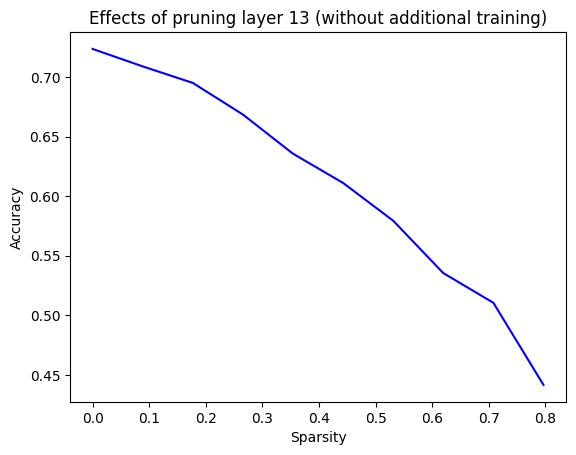

[0.0, 0.08850915702111369, 0.17701831404222737, 0.2655274710633411, 0.35403662808445474, 0.4425457851055684, 0.5310549421266823, 0.6195640991477959, 0.7080732561689095, 0.7965824131900232]


In [117]:
import copy
import pandas as pd

#load model
model = keras.models.load_model('model_fixed.keras')
weights = model.get_weights()

temp_weights = copy.deepcopy(model.get_weights())
num_weights = 0
for t in temp_weights:
   num_weights += np.prod(t.shape)


weights_copy = copy.deepcopy(model.get_weights())

for i, (l, j) in enumerate(zip([13], [4])):

    acc_list = []
    sparsity = []

    for thr in np.arange(0, 1.0, 0.1):

      temp_weights = copy.deepcopy(weights_copy)

      weights_rewards = np.load(f'./data_{l}.npy')

      temp_weights = zero_weights(temp_weights, weights_rewards, j, thr)

      sparse = (thr*np.prod(temp_weights[j*2].shape)+thr*np.prod(temp_weights[j*2+1].shape))/num_weights

      sparsity.append(sparse)

      model.set_weights(temp_weights)

      # evaluate again to see how the accuracy changes
      results = model.evaluate(val_images, val_labels, batch_size=128, verbose=0)
      acc_list.append(results[1])

    plt.Figure()
    plt.plot(sparsity, acc_list, 'b-')
    plt.ylabel('Accuracy')
    plt.xlabel('Sparsity')
    plt.title(f'Effects of pruning layer 13 (without additional training)')
    plt.show()
    plt.close()

df = pd.DataFrame({"sparse" : sparsity, "acc" : acc_list})
df.to_csv("pareto_results_3_un.csv", index=False)

print(sparsity)


In [60]:
#load model
model = keras.models.load_model('model_fixed.keras')
weights = model.get_weights()

temp_weights = copy.deepcopy(model.get_weights())
num_weights = 0
for t in temp_weights:
   num_weights += np.prod(t.shape)


temp_weights = copy.deepcopy(model.get_weights())

for i, (l, j, t) in enumerate(zip([13], [4], [0.9])):

    weights_rewards = np.load(f'./data_{l}.npy')

    temp_weights = zero_weights(temp_weights, weights_rewards, j, t)

model.set_weights(temp_weights)

# evaluate again to see how the accuracy changes
results = model.evaluate(val_images, val_labels, batch_size=128)
model.save('model_pruned_90_2.keras')

20/20 [==============================] - 1s 9ms/step - loss: 1.4681 - accuracy: 0.4851


# Further training for model

In [8]:
import pandas as pd
import copy

def further_training(model, model_name, thr):

  print('Working on threshold: ', thr)

  weights_rewards = np.load(f'./data_13.npy')
  temp_weights = copy.deepcopy(model.get_weights())
  temp_weights = zero_weights(temp_weights, weights_rewards, 4, thr)

  model.set_weights(temp_weights)
  # model = keras.models.load_model(model_name+'.keras')

  results = model.evaluate(val_images, val_labels, batch_size=2525)

  for i in range(10):
      print(f'Epoch {i}')
      history = model.fit(train_images, train_labels, batch_size=32, epochs=1,
                      validation_data=(val_images, val_labels))

      temp_weights = copy.deepcopy(model.get_weights())
      temp_weights = zero_weights(temp_weights, weights_rewards, 4, thr)

      model.set_weights(temp_weights)

  del temp_weights

  return model


temp_weights = copy.deepcopy(model.get_weights())
num_weights = 0
num_nonzeros = 0
for t in temp_weights:
   num_weights += np.prod(t.shape)
   num_nonzeros += np.count_nonzero(t)

sparse = 1 - num_nonzeros/num_weights

acc_list = []
sparse_list = []

model = keras.models.load_model('model_fixed.keras')

for i in np.arange(0, 1.0, 0.1):

    model = keras.models.load_model('model_fixed.keras')
    model_name = f'model_pruned_{i*10}'
    model = further_training(model, model_name, i)

    results = model.evaluate(val_images, val_labels, batch_size=2525)

    #calculate sparsity
    temp_weights = copy.deepcopy(model.get_weights())
    num_nonzeros = 0
    for t in temp_weights:
        num_nonzeros += np.count_nonzero(t)
    sparse_list.append(1 - num_nonzeros/num_weights)

    acc_list.append(results[1])

df = pd.DataFrame({"sparse" : sparse_list, "acc" : acc_list})
df.to_csv("pareto_results.csv", index=False)

# model.save(model_name+'retrained.keras')

Working on threshold:  0.0
1/1 [==============================] - 1s 1s/step - loss: 0.7137 - accuracy: 0.7236
Epoch 0
703/703 [==============================] - 9s 6ms/step - loss: 0.6143 - accuracy: 0.7709 - val_loss: 0.7454 - val_accuracy: 0.7141
Epoch 1
703/703 [==============================] - 4s 6ms/step - loss: 0.6110 - accuracy: 0.7743 - val_loss: 0.7145 - val_accuracy: 0.7283
Epoch 2
703/703 [==============================] - 5s 7ms/step - loss: 0.6015 - accuracy: 0.7771 - val_loss: 0.7109 - val_accuracy: 0.7319
Epoch 3
703/703 [==============================] - 4s 6ms/step - loss: 0.5993 - accuracy: 0.7742 - val_loss: 0.7341 - val_accuracy: 0.7204
Epoch 4
703/703 [==============================] - 4s 6ms/step - loss: 0.5913 - accuracy: 0.7787 - val_loss: 0.7073 - val_accuracy: 0.7275
Epoch 5
703/703 [==============================] - 4s 5ms/step - loss: 0.5833 - accuracy: 0.7822 - val_loss: 0.7164 - val_accuracy: 0.7263
Epoch 6
703/703 [==============================] - 4s 6

In [52]:
df = pd.DataFrame({"sparse" : sparse_list, "acc" : acc_list})
df.to_csv("pareto_results.csv", index=False)

In [53]:
print(df)

   sparse       acc
0     0.0  0.736634
1     0.1  0.734257
2     0.2  0.732673
3     0.3  0.733861
4     0.4  0.733861
5     0.5  0.728317
6     0.6  0.706535
7     0.7  0.719604
8     0.8  0.672871
9     0.9  0.640000


# Calculate sparsity

In [9]:
temp_weights = copy.deepcopy(model.get_weights())
num_weights = 0
num_nonzeros = 0
for t in temp_weights:
   num_weights += np.prod(t.shape)
   num_nonzeros += np.count_nonzero(t)

sparse = 1 - num_nonzeros/num_weights

print(sparse)

0.7951994576115683


# Extract weights and save

In [63]:
# you need to save the model's weights, naming it 'my_model_weights.h5'
model.save_weights("my_model_weights.h5")

# running this cell will immediately download a file called 'my_model_weights.h5'
from google.colab import files
files.download("my_model_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot Pareto Front

In [129]:
#load data from other methods
import pandas as pd

data_list = []
unt_data_list = []

folder = '/content/data'
file_list = os.listdir(folder)

for i in range(3):

  data = pd.read_csv(os.path.join(folder, f'pareto_results_{i+1}.csv'))
  data.dropna(axis=1, how='all', inplace=True)
  data.dropna(axis=0, inplace=True)
  print(data)
  all_data = np.concatenate([data['acc'].to_numpy().reshape(-1,1), data['sparse'].to_numpy().reshape(-1,1)], axis=1)
  data_list.append(all_data)

for i in range(3):

  data = pd.read_csv(os.path.join(folder, f'pareto_results_{i+1}_un.csv'))
  data.dropna(axis=1, how='all', inplace=True)
  data.dropna(axis=0, inplace=True)
  all_data = np.concatenate([data['acc'].to_numpy().reshape(-1,1), data['sparse'].to_numpy().reshape(-1,1)], axis=1)
  unt_data_list.append(all_data)

   sparse    acc
0   0.000  0.743
1   0.317  0.727
2   0.588  0.757
3   0.768  0.719
4   0.852  0.722
5   0.880  0.626
6   0.886  0.398
7   0.888  0.224
8   0.888  0.192
9   0.889  0.192
     sparse    acc
0   0.00000  0.725
1   0.00248  0.725
2   0.00749  0.730
3   0.06630  0.722
4   0.19100  0.699
5   0.40500  0.687
6   0.60900  0.626
7   0.82000  0.501
8   0.93100  0.368
9   0.96700  0.342
10  0.98900  0.268
     sparse       acc
0  0.000000  0.736634
1  0.088509  0.734257
2  0.177018  0.732673
3  0.265527  0.733861
4  0.354037  0.733861
5  0.442546  0.728317
6  0.531055  0.706535
7  0.619564  0.719604
8  0.708073  0.672871
9  0.796582  0.640000


In [130]:
def calculate_pareto(data_list):

  fronts = []
  for i in range(len(data_list)):

    all_data = data_list[i]

    sum_coords = np.sum(all_data, axis=1)
    sorted_points = all_data[np.argsort(sum_coords)[::-1]]

    on_front = []

    for j in range(sorted_points.shape[0]):

        if (np.argmax(sorted_points[:j+1, 0]) == j) or (np.argmax(sorted_points[:j+1, 1]) == j):

          on_front.append(j)

    on_front= sorted_points[np.array(on_front)]

    sorted_data_x = on_front[on_front[:, 1].argsort()]
    fronts.append(sorted_data_x)

  return fronts

fronts = calculate_pareto(data_list)
unt_fronts = calculate_pareto(unt_data_list)


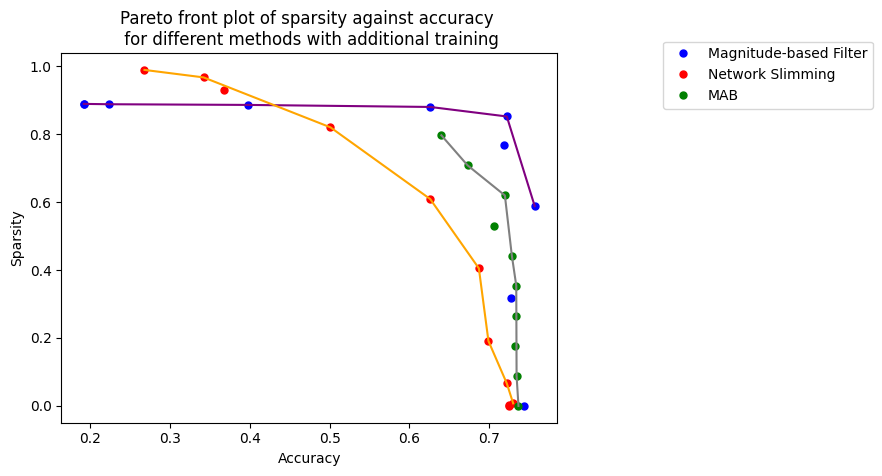

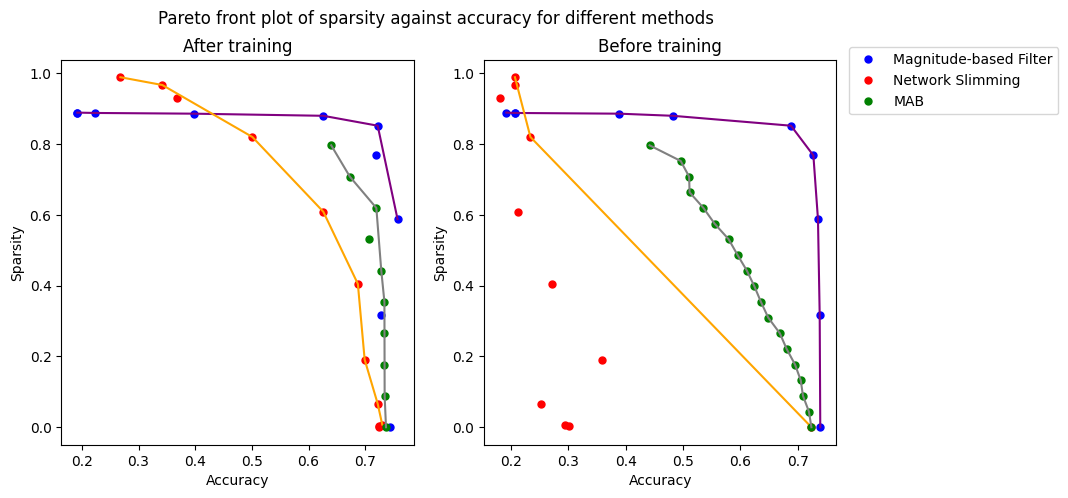

In [131]:
color = ['b.', 'r.', 'g.']
color_pareto = ['purple', 'orange', 'gray']
name_list = ['Magnitude-based Filter', 'Network Slimming', 'MAB']

plt.Figure()

#plot points
for i in range(3):
    plt.plot(data_list[i][:, 0], data_list[i][:, 1], color[i], label=name_list[i], markersize=10)
    plt.plot(fronts[i][:, 0], fronts[i][:, 1], '-', color=color_pareto[i])


plt.xlabel('Accuracy')
plt.ylabel('Sparsity')
plt.title('Pareto front plot of sparsity against accuracy \n for different methods with additional training')
plt.legend(bbox_to_anchor=(1.65, 1.05))
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#plot points
data_list_2 = [data_list, unt_data_list]
front_list_2 = [fronts, unt_fronts]

for j in range(2):
  for i in range(3):
      ax[j].plot(data_list_2[j][i][:, 0], data_list_2[j][i][:, 1], color[i], label=name_list[i], markersize=10)
      ax[j].plot(front_list_2[j][i][:, 0], front_list_2[j][i][:, 1], '-', color=color_pareto[i])

  ax[j].set_xlabel('Accuracy')
  ax[j].set_ylabel('Sparsity')
  if j== 0:
    ax[j].set_title('After training')
  else:
    ax[j].set_title('Before training')
    ax[j].legend(bbox_to_anchor=(1.65, 1.05))

fig.suptitle('Pareto front plot of sparsity against accuracy for different methods')
plt.show()